## MoA Kaggle- Drug Discovery

#### MultiLabel Classification problem

[Kaggle Link](https://www.kaggle.com/c/lish-moa/data)

In cuurent approaches for Drug discovery, Scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

Effects of a drug on the protien target

**Metric** is average logloss for all classes

#### Xgboost 1 variable paramTuning and Feature Importance

Out of 206 target variables, cyclooxygenase_inhibitor has highest LogLoss 0f 0.092 with Deep neuarl net, 
Goal is to reduce this with xgboost.

See work on predWork notebook for details about individual losses for variables

Why not use scikit-learn grid searches
* Added flexibility
* Ease of analyzing param effects
* We can add a additional validation set, which is not part of the Cv


### Approach

* Build on 50K-100k sample, if dataset is larger
* Param tune with cv,
* Pick least overfitted and best performing models
* var reduction based on impotances and voting
* regularization
* drop vars 1 at a time and coorrelated vars 
* Final grid search - on reduced var list
* pick the least overfitted model with accepatble loss reduction as final model



In [1]:

import numpy as np
import pandas as pd
import xgboost as xgb

SEED = 42

np.random.seed(SEED)

### Supporting Fns


In [12]:
def GridParamTune(dtrain,gridParams,EvalMetric,params,Drop=1,verbose=1):
    '''
    Xgboost Param tuning
    Author: Taran
    
    Given a params dictionary this function implements Grid and random search
    The cv object can be replaced for any other model
    
    Args - dTrain matrix,
            gridParams A parameters dictinary with candidate search space
            Drop Rate - for  Random search [0,1]
            verbose 0 0r 1 
            params  ---not to be tuned parameters
            EvalMetric  -- takes 1 eval metric
    Output
    Returns a df with results for each params
    Additional dependency itertools
    
    '''
    import itertools
    #paramers passed
    paramNames = list(gridParams.keys())
    
    results = []
    ### iterate over all combinations
    for row in itertools.product(*gridParams.values()):
        ### random search threshold
        if np.random.random(1)[0] < Drop:
            continue 
        
        # insert values into param dict
        for i in range(len(row)):
            params[paramNames[i]] = row[i]
            
        # train model for given params    
        cvN = xgb.cv(
                    params,
                    dtrain,
                    num_boost_round=1000,
                    seed=42,
                    nfold=5,
                    metrics={EvalMetric},
                    early_stopping_rounds=25
                )
        #get results 
        bestRound= cvN[f'test-{EvalMetric}-mean'].argmin()
        trainMetric = cvN[f'train-{EvalMetric}-mean'][bestRound]
        testMetric =cvN[f'test-{EvalMetric}-mean'][bestRound]
        overfit = ((cvN[f'test-{EvalMetric}-mean'][bestRound]/cvN[f'train-{EvalMetric}-mean'][bestRound]) -1)*100
        
        #unlist
        tempResults=[list(params.values())[1:],bestRound,trainMetric,testMetric,overfit]      

        results.append(list(itertools.chain.from_iterable(i if isinstance(i, list) else [i] for i in tempResults)))
         
    colNames=[paramNames,'bestRound',f'train-{EvalMetric}',f'test-{EvalMetric}','overfit']              
    df = pd.DataFrame(results,columns=list(itertools.chain.from_iterable(i if isinstance(i, list) else [i] for i in colNames)))
                  
    return df

def overFitRelations(paramName,paramResults=paramResults):
    '''
    Arg - paramName
    returns a plot and a df showing over fit relation
    '''
    df = paramResults.groupby([paramName])['overfit'].mean()
    print(df.plot.bar(title=f'{paramName} vs overfitting'))
    return df

def getLogLoss(y,yhat):
    '''
    logloss
    '''
    assert len(y)==len(yhat)
    eps= 1e-12
    
    yhat= np.clip(yhat,eps,1-eps)
    return -1*np.mean(y*np.log(yhat) + (1-y)*np.log(1-yhat))


def PreProcessX(df):
    '''
    Preprocessing for independent  vars
    encode categoricals
    
    returns processed df,
    '''
    df['cp_dose'] = (df['cp_dose'] == 'D1').astype(int)
    df['cp_type'] = (df['cp_type'] == 'trt_cp').astype(int)
    
    return df

def flattenList(myList):
    '''
    Flattens a list and returns it
    '''
    import itertools
    return list(itertools.chain.from_iterable(i if isinstance(i, list) else [i] for i in myList))

In [3]:
xAll = pd.read_csv('../Data/train_features.csv')
yAll = pd.read_csv('../Data/train_targets_scored.csv')



In [4]:
xAll = PreProcessX(xAll)

trainIds= xAll['sig_id'].sample(frac=0.8,random_state=SEED)

In [5]:
xTrain = xAll[xAll['sig_id'].isin(trainIds)]
yTrain = yAll[yAll['sig_id'].isin(trainIds)]
xValid = xAll[~xAll['sig_id'].isin(trainIds)]
yValid = yAll[~yAll['sig_id'].isin(trainIds)]
print(f'xTrain {xTrain.shape} yTrain {yTrain.shape} xValid {xValid.shape} yValid {yValid.shape}')

xTrain (19051, 876) yTrain (19051, 207) xValid (4763, 876) yValid (4763, 207)


In [6]:
idList=['sig_id']
xTrain=xTrain.drop(idList,axis=1)
xValid=xValid.drop(idList,axis=1)
yTrain=yTrain.drop(idList,axis=1)
yValid=yValid.drop(idList,axis=1)

In [7]:
dtrain = xgb.DMatrix(xTrain, label=yTrain['cyclooxygenase_inhibitor'])

In [9]:
# not tuning gamma and max leaves # to be tuned based on overfit

NumRows =xTrain.shape[0]*0.8 ### 0.8 is due to 5 fold cv
gridParams = {
   
    'max_depth' : [4,6,8],
    'eta' : [0.01,0.05,0.1],
    'colsample_bytree' : [0.2,0.5,1],
    'min_child_weight' : [1,int(NumRows*0.005)]
}


In [10]:
# not to be tuned params
params = {
    'objective':'binary:logistic'
}

In [13]:
%time paramResults=GridParamTune(dtrain=dtrain,gridParams=gridParams,EvalMetric='logloss',params=params)


CPU times: user 20h 57min 12s, sys: 54 s, total: 20h 58min 6s
Wall time: 1h 46min 24s


#### Selection criteria

Sort by logloss,

Obs
All models got trained fully bestRound < Numrounds

Since the goal was to regularize the model later,
we can pick 5 with lower log loss and 1 least overfitted from those 

In trhe second stage we will pick the model with the lowest logloss.


In [15]:
paramResults.sort_values(['test-logloss'])

,max_depth,eta,colsample_bytree,min_child_weight,bestRound,train-logloss,test-logloss,overfit
2,4,0.01,0.5,1,676,0.059015,0.087648,48.517844
14,4,0.10,0.5,1,56,0.065939,0.087667,32.950961
0,4,0.01,0.2,1,727,0.057525,0.087668,52.398419
4,4,0.01,1.0,1,617,0.061563,0.087897,42.775554
10,4,0.05,1.0,1,123,0.061070,0.087942,44.002109
12,4,0.10,0.2,1,72,0.056511,0.087970,55.669162
16,4,0.10,1.0,1,62,0.060099,0.087984,46.397290
6,4,0.05,0.2,1,146,0.056675,0.087984,55.244148
20,6,0.01,0.5,1,568,0.042952,0.087992,104.860309
8,4,0.05,0.5,1,126,0.061466,0.088024,43.208884


AxesSubplot(0.125,0.125;0.775x0.755)


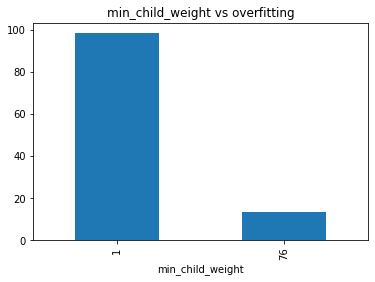

In [24]:
overFitRelations('min_child_weight')

AxesSubplot(0.125,0.125;0.775x0.755)


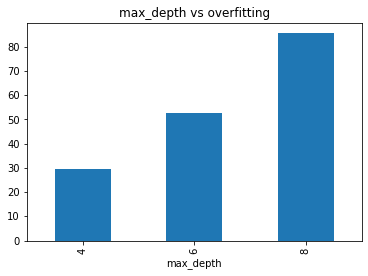

In [253]:
overFitRelations('max_depth')

AxesSubplot(0.125,0.125;0.775x0.755)


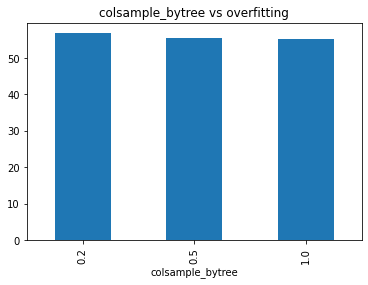

In [25]:
overFitRelations('colsample_bytree')

In [53]:
maxDepth = list(paramResults.sort_values(['test-logloss'])[:2]['max_depth'].values)

In [54]:
maxDepth.append(list(paramResults.sort_values(['overfit'])[:2]['max_depth'].values))
maxDepth

[4, 4, [4, 4]]

In [48]:
def flattenList(myList):
    '''
    Flattens a list and returns it
    '''
    import itertools
    return list(itertools.chain.from_iterable(i if isinstance(i, list) else [i] for i in myList))

In [55]:
set(flattenList(maxDepth))

{4}

In [62]:
def getParams(paramName,paramResults,n=1):
    '''
    selects unique params from df returned by paramResults df
    n number of params sets selected
    '''
    temp = list(paramResults.sort_values(['test-logloss'])[:2][paramName].values)
    temp.append(list(paramResults.sort_values(['overfit'])[:2][paramName].values))
    return set(flattenList(temp))

In [63]:
getParams('max_depth',paramResults=paramResults)

{4}

In [64]:
getParams(paramName='min_child_weight',paramResults=paramResults)

{1, 76}

In [65]:
getParams(paramName='colsample_bytree',paramResults=paramResults)

{0.2, 0.5}

In [66]:
getParams(paramName='eta',paramResults=paramResults)

{0.01, 0.1}

In [72]:
paramResults.sort_values(['overfit'])[:1].append(
paramResults.sort_values(['test-logloss'])[:1])

,max_depth,eta,colsample_bytree,min_child_weight,bestRound,train-logloss,test-logloss,overfit
13,4,0.10,0.2,76,74,0.080109,0.088934,11.015936
2,4,0.01,0.5,1,676,0.059015,0.087648,48.517844


#### Feature importances from selected models

Features are correlated so we might see lot of variation in important features returned by different models.

As we increase number of trees we might see the number of features returned also increase,

We will take average of feature importances returned( normalized gains) and select vraibles with cummulative importance <0.80,



In [188]:
## Get Feature importances
# least over fitted
NumRows =xTrain.shape[0]


params1 = {
    'max_depth' : 4,
    'eta' : 0.1,
    'colsample_bytree' : 0.2,
    'min_child_weight' : int(NumRows*0.005),
    'objective':'multi:softprob',
    'num_class':2
}


params2 = {
    'max_depth' : 4,
    'eta' : 0.01,
    'colsample_bytree' : 0.5,
    'min_child_weight' : 1,
    'objective':'multi:softprob',
    'num_class':2
}



In [190]:
%time mod1 = xgb.train(params1,dtrain, num_boost_round=74)

CPU times: user 47.3 s, sys: 23.9 ms, total: 47.4 s
Wall time: 4.04 s


In [191]:
%time mod2 = xgb.train(params2,dtrain, num_boost_round=676)

CPU times: user 21min 27s, sys: 200 ms, total: 21min 27s
Wall time: 1min 48s


In [192]:
## Results on valid test
print(getLogLoss(yValid['cyclooxygenase_inhibitor'],mod1.predict(xgb.DMatrix(xValid))[:,1]))
print(getLogLoss(yValid['cyclooxygenase_inhibitor'],mod2.predict(xgb.DMatrix(xValid))[:,1]))

0.086167923948375
0.08501716379982831


In [247]:
imp1 =pd.DataFrame(mod1.get_score(importance_type='gain').items(),
             columns=['variable','Gain']).sort_values(['Gain'],ascending=False).reset_index(drop=True)
imp2 =pd.DataFrame(mod2.get_score(importance_type='gain').items(),
             columns=['variable','Gain']).sort_values(['Gain'],ascending=False).reset_index(drop=True)
imp = pd.merge(imp2,imp1,how='left',on=['variable'],suffixes=['_1', '_2'])

imp= imp.fillna(0)

#Normalizing
imp['Gain_1'] = imp['Gain_1']/imp['Gain_1'].sum()
imp['Gain_2'] = imp['Gain_2']/imp['Gain_2'].sum()

#average
imp['AvgGain'] = (imp['Gain_1']+imp['Gain_2'])*100/2
imp = imp.sort_values('AvgGain',ascending=False).reset_index(drop=True)

imp['CummProp'] = imp['AvgGain'].cumsum()


In [252]:
imp[imp['CummProp'] <= 80]

,variable,Gain_1,Gain_2,AvgGain,CummProp
0,g-526,0.002443,0.008485,0.546406,0.546406
1,g-158,0.001187,0.008856,0.502161,1.048568
2,g-459,0.001501,0.008046,0.477393,1.525961
3,g-536,0.002037,0.007478,0.475750,2.001711
4,g-515,0.001520,0.007649,0.458484,2.460195
...,...,...,...,...,...
385,g-64,0.001628,0.000000,0.081389,79.605129
386,g-419,0.001622,0.000000,0.081089,79.686218
387,g-378,0.001618,0.000000,0.080916,79.767135
388,g-390,0.001616,0.000000,0.080824,79.847959


In [256]:
paramResults.to_csv('../dumps/1stGrid_cyclooxygenase_inhibitor.csv')
imp.to_csv('../dumps/VarImp_cyclooxygenase_inhibitor.csv')

In [258]:
xTrain[imp[imp['CummProp'] <= 80]['variable']].shape

(19051, 390)

### 2nd grid serach on the selected varibles

Will be based on the results from 1st with added regularizers

In [259]:
## selected variables
dtrain = xgb.DMatrix(xTrain[imp[imp['CummProp'] <= 80]['variable']], label=yTrain['cyclooxygenase_inhibitor'])

In [261]:

NumRows =xTrain.shape[0]*0.8 ### 0.8 is due to 5 fold cv
gridParams = {
   
    'max_depth' : [3,4,5]
    ,'eta' : [0.01,0.1]
    ,'colsample_bytree' : [0.3,0.6]
    ,'gamma': [0,0.1,0.5]# 0 is default
    ,'min_child_weight' : [1,int(NumRows*0.0025),int(NumRows*0.005)]# 1 is default
}


In [262]:
params = {
    'objective':'binary:logistic'
}
%time paramResults2=GridParamTune(dtrain=dtrain,gridParams=gridParams,EvalMetric='logloss',params=params)


CPU times: user 20h 38min 50s, sys: 27.1 s, total: 20h 39min 17s
Wall time: 1h 44min 13s


In [265]:
paramResults2.sort_values(['test-logloss']).head(20)

,max_depth,eta,colsample_bytree,gamma,min_child_weight,bestRound,train-logloss,test-logloss,overfit
42,4,0.01,0.3,0.5,1,978,0.045069,0.086095,91.026728
12,3,0.01,0.6,0.1,1,993,0.059650,0.086119,44.373661
36,4,0.01,0.3,0.0,1,948,0.046388,0.086121,85.655218
24,3,0.10,0.3,0.5,1,116,0.054534,0.086127,57.934558
75,5,0.01,0.3,0.1,1,789,0.040434,0.086135,113.026166
78,5,0.01,0.3,0.5,1,763,0.042060,0.086221,104.998145
9,3,0.01,0.6,0.0,1,993,0.059616,0.086224,44.633134
45,4,0.01,0.6,0.0,1,917,0.046019,0.086256,87.434755
33,3,0.10,0.6,0.5,1,143,0.045286,0.086256,90.468662
39,4,0.01,0.3,0.1,1,899,0.048781,0.086265,76.841393


#### We have improved on logloss

best round greater than >975 means model has the potential to train more

We can pick least over fitted from top 5 with lowest loss or take 1 model from least overfitted ones with less drop in performance 



In [266]:
def overFitRelations(paramName,paramResults):
    '''
    Arg - paramName
    returns a plot and a df showing over fit relation
    '''
    df = paramResults.groupby([paramName])['overfit'].mean()
    print(df.plot.bar(title=f'{paramName} vs overfitting'))
    return df

In [270]:
paramResults2.sort_values(['overfit']).head(10)

,max_depth,eta,colsample_bytree,gamma,min_child_weight,bestRound,train-logloss,test-logloss,overfit
2,3,0.01,0.3,0.0,76,828,0.080302,0.088480,10.184330
14,3,0.01,0.6,0.1,76,825,0.079854,0.088451,10.765370
11,3,0.01,0.6,0.0,76,843,0.079668,0.088456,11.031029
17,3,0.01,0.6,0.5,76,849,0.079632,0.088439,11.060406
38,4,0.01,0.3,0.0,76,789,0.079599,0.088442,11.109185
65,4,0.10,0.6,0.0,76,74,0.079445,0.088307,11.154327
41,4,0.01,0.3,0.1,76,796,0.079510,0.088411,11.194818
29,3,0.10,0.6,0.0,76,86,0.079372,0.088459,11.448564
8,3,0.01,0.3,0.5,76,989,0.078673,0.088411,12.378134
50,4,0.01,0.6,0.1,76,827,0.078501,0.088267,12.440319


AxesSubplot(0.125,0.125;0.775x0.755)


min_child_weight
1     78.034963
38    31.890048
76    15.448526
Name: overfit, dtype: float64

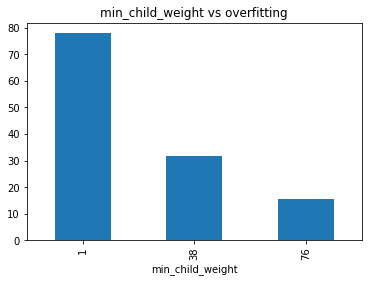

In [272]:
overFitRelations('min_child_weight',paramResults=paramResults2)

AxesSubplot(0.125,0.125;0.775x0.755)


max_depth
3    32.269339
4    44.243258
5    48.860940
Name: overfit, dtype: float64

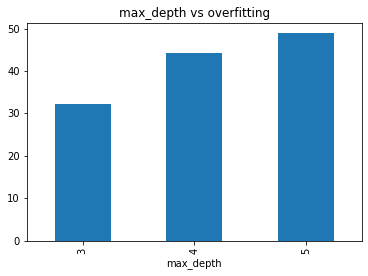

In [273]:
overFitRelations('max_depth',paramResults=paramResults2)

AxesSubplot(0.125,0.125;0.775x0.755)


gamma
0.0    41.256922
0.1    42.926565
0.5    41.190050
Name: overfit, dtype: float64

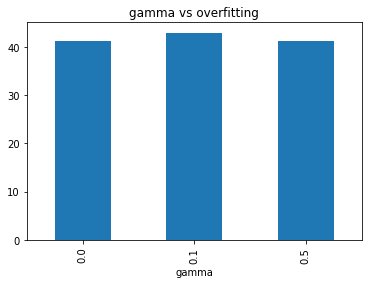

In [274]:
overFitRelations('gamma',paramResults=paramResults2)

gamma is harder to tune,

For this dataset We can control overfitting by tweaking min_child_weight



In [277]:
paramResults2['test-logloss'].min()

0.0860946

In [280]:
paramResults2['perfDrop'] = paramResults2['test-logloss']/paramResults2['test-logloss'].min()
paramResults2.sort_values(['overfit']).head(20)

,max_depth,eta,colsample_bytree,gamma,min_child_weight,bestRound,train-logloss,test-logloss,overfit,perfDrop
2,3,0.01,0.3,0.0,76,828,0.080302,0.088480,10.184330,1.027707
14,3,0.01,0.6,0.1,76,825,0.079854,0.088451,10.765370,1.027368
11,3,0.01,0.6,0.0,76,843,0.079668,0.088456,11.031029,1.027430
17,3,0.01,0.6,0.5,76,849,0.079632,0.088439,11.060406,1.027235
38,4,0.01,0.3,0.0,76,789,0.079599,0.088442,11.109185,1.027263
65,4,0.10,0.6,0.0,76,74,0.079445,0.088307,11.154327,1.025697
41,4,0.01,0.3,0.1,76,796,0.079510,0.088411,11.194818,1.026905
29,3,0.10,0.6,0.0,76,86,0.079372,0.088459,11.448564,1.027467
8,3,0.01,0.3,0.5,76,989,0.078673,0.088411,12.378134,1.026903
50,4,0.01,0.6,0.1,76,827,0.078501,0.088267,12.440319,1.025233


In [281]:
paramResults2.sort_values(['test-logloss']).head(20)

,max_depth,eta,colsample_bytree,gamma,min_child_weight,bestRound,train-logloss,test-logloss,overfit,perfDrop
42,4,0.01,0.3,0.5,1,978,0.045069,0.086095,91.026728,1.000000
12,3,0.01,0.6,0.1,1,993,0.059650,0.086119,44.373661,1.000279
36,4,0.01,0.3,0.0,1,948,0.046388,0.086121,85.655218,1.000307
24,3,0.10,0.3,0.5,1,116,0.054534,0.086127,57.934558,1.000381
75,5,0.01,0.3,0.1,1,789,0.040434,0.086135,113.026166,1.000469
78,5,0.01,0.3,0.5,1,763,0.042060,0.086221,104.998145,1.001473
9,3,0.01,0.6,0.0,1,993,0.059616,0.086224,44.633134,1.001505
45,4,0.01,0.6,0.0,1,917,0.046019,0.086256,87.434755,1.001870
33,3,0.10,0.6,0.5,1,143,0.045286,0.086256,90.468662,1.001879
39,4,0.01,0.3,0.1,1,899,0.048781,0.086265,76.841393,1.001979


The model with the max depth 3 will be mnore restrictive, as it will have max of 8 leaves, For var reduction I will prefer model which allows more interactions, so depth of 4,

The selected model upto this step is 4,0.01,0.3,0.5,1,978

In [283]:
paramResults2[(paramResults2['max_depth']==4)  & (paramResults2['colsample_bytree']==0.3)]


,max_depth,eta,colsample_bytree,gamma,min_child_weight,bestRound,train-logloss,test-logloss,overfit,perfDrop
36,4,0.01,0.3,0.0,1,948,0.046388,0.086121,85.655218,1.000307
37,4,0.01,0.3,0.0,38,992,0.065879,0.087265,32.462849,1.013597
38,4,0.01,0.3,0.0,76,789,0.079599,0.088442,11.109185,1.027263
39,4,0.01,0.3,0.1,1,899,0.048781,0.086265,76.841393,1.001979
40,4,0.01,0.3,0.1,38,990,0.065949,0.087196,32.217623,1.012795
41,4,0.01,0.3,0.1,76,796,0.079510,0.088411,11.194818,1.026905
42,4,0.01,0.3,0.5,1,978,0.045069,0.086095,91.026728,1.000000
43,4,0.01,0.3,0.5,38,752,0.071998,0.087586,21.650601,1.017323
44,4,0.01,0.3,0.5,76,999,0.077507,0.088307,13.934153,1.025702
54,4,0.10,0.3,0.0,1,97,0.043562,0.086544,98.669483,1.005224


#### Variable reduction

Since we still have 390 features we can aggresively reduce them further

In [284]:
###  Gget 20% sampel for testing
xTrain.shape

(19051, 875)

In [302]:
sVars= imp[imp['CummProp'] <= 80]['variable']

In [313]:
from sklearn.model_selection import train_test_split

xTrainVars, xTestVars, yTrainVars, yTestVars = train_test_split(xTrain[sVars],
                                                                yTrain['cyclooxygenase_inhibitor'], 
                                                                test_size=0.3, random_state=42)

In [316]:
print(f'{xTrainVars.shape}, {xTestVars.shape}, {yTrainVars.shape}, {yTestVars.shape}')

(13335, 390), (5716, 390), (13335,), (5716,)


In [314]:
NumRows =xTrainVars.shape[0]

# 4,0.01,0.3,0.5,1,978
params1 = {
    'max_depth' : 4,
    'eta' : 0.01,
    'colsample_bytree' : 0.3,
    'min_child_weight' : 1,
    'gamma': 0.5,
    'objective':'multi:softprob',
    'num_class':2
}

dtrain = xgb.DMatrix(xTrainVars, label=yTrainVars)

In [317]:
%time mod1 = xgb.train(params1,dtrain, num_boost_round=978)

CPU times: user 6min 8s, sys: 52 ms, total: 6min 8s
Wall time: 30.9 s


In [318]:
print(f'train loss {getLogLoss(yTrainVars,mod1.predict(xgb.DMatrix(xTrainVars))[:,1])}')
print(f'test loss {getLogLoss(yTestVars,mod1.predict(xgb.DMatrix(xTestVars))[:,1])}')

train loss 0.040038868491816794
test loss 0.08763258157614282


In [319]:
#test loss 0.08763258157614282   Log loss we are starting with

testLoss = getLogLoss(yTestVars,mod1.predict(xgb.DMatrix(xTestVars))[:,1])
testLoss

0.08763258157614282

In [320]:
imp =pd.DataFrame(mod1.get_score(importance_type='gain').items(),
             columns=['variable','Gain']).sort_values(['Gain'],ascending=False).reset_index(drop=True)
imp

,variable,Gain
0,g-228,5.603137
1,g-319,5.447839
2,g-38,5.163427
3,g-714,5.114439
4,g-40,4.918322
...,...,...
385,g-426,1.604592
386,g-59,1.542952
387,g-415,1.505278
388,g-629,1.386211


In [324]:
sVars = imp['variable'][::-1]

In [340]:
# dropping least important variables 
def dropVars(sVars,n):
    '''
    drop variables upto n increasingly from 1 to n
    
    returns result dropping variables
    '''
    results ={}
    for i in range(1,n):
        
        remainingVars = sVars[i:] # drop variable
        dtrain = xgb.DMatrix(xTrainVars[remainingVars], label=yTrainVars)
        mod = xgb.train(params1,dtrain, num_boost_round=978) ## params1 are same selected variables
        rLoss = getLogLoss(yTestVars,mod.predict(xgb.DMatrix(xTestVars[remainingVars]))[:,1]) 
        results[f'dropped_{i}'] = (rLoss,(testLoss-rLoss))
    
    return results

In [ ]:
%time dropVarList = dropVars(sVars,200)

In [337]:
dropVarList

{'dropped_1': (0.08763258157614282, 0.0),
 'dropped_2': (0.08763258157614282, 0.0),
 'dropped_3': (0.08763258157614282, 0.0),
 'dropped_4': (0.08763258157614282, 0.0),
 'dropped_5': (0.08763258157614282, 0.0),
 'dropped_6': (0.08763258157614282, 0.0),
 'dropped_7': (0.08763258157614282, 0.0),
 'dropped_8': (0.08763258157614282, 0.0),
 'dropped_9': (0.08763258157614282, 0.0),
 'dropped_10': (0.08763258157614282, 0.0),
 'dropped_11': (0.08763258157614282, 0.0),
 'dropped_12': (0.08763258157614282, 0.0),
 'dropped_13': (0.08763258157614282, 0.0),
 'dropped_14': (0.08763258157614282, 0.0),
 'dropped_15': (0.08763258157614282, 0.0),
 'dropped_16': (0.08763258157614282, 0.0),
 'dropped_17': (0.08763258157614282, 0.0),
 'dropped_18': (0.08763258157614282, 0.0),
 'dropped_19': (0.08763258157614282, 0.0),
 'dropped_20': (0.08763258157614282, 0.0),
 'dropped_21': (0.08763258157614282, 0.0),
 'dropped_22': (0.08763258157614282, 0.0),
 'dropped_23': (0.08763258157614282, 0.0),
 'dropped_24': (0.08